# Applying Low Pass Filter

In [1]:
%matplotlib nbagg
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import scipy as sp
from scipy import signal
from scipy.fftpack import fft,fftfreq,ifft,rfft,rfftfreq,irfft


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning,RuntimeWarning))

In [3]:
dataFile = "Sample-Data/28A18305A90B_20180315175916.csv"
df = pd.read_csv(dataFile,skiprows=5)
df.head()

,//ARTIFACT,NUM,DATE,ACC_X,ACC_Y,ACC_Z,EOG_L1,EOG_R1,EOG_L2,EOG_R2,EOG_H1,EOG_H2,EOG_V1,EOG_V2
0,NaN,1,2018/03/15 17:59:16.13,-380,2276,-16281,138,170,-11,20,-32,-31,-154,-4
1,NaN,2,2018/03/15 17:59:16.15,-391,2195,-16210,48,73,114,145,-25,-31,-60,-129
2,NaN,3,2018/03/15 17:59:16.17,-357,2205,-16157,-35,-8,142,172,-27,-30,21,-157
3,NaN,4,2018/03/15 17:59:16.19,-372,2304,-16237,-3,28,37,62,-31,-25,-12,-49
4,NaN,5,2018/03/15 17:59:16.21,-309,2317,-16326,113,150,-44,-15,-37,-29,-131,29


In [4]:
df["DATE"] = pd.to_datetime(df["DATE"])
df.drop(['//ARTIFACT','NUM'],axis=1,inplace=True)
df.set_index("DATE",inplace=True)
df.head()

,ACC_X,ACC_Y,ACC_Z,EOG_L1,EOG_R1,EOG_L2,EOG_R2,EOG_H1,EOG_H2,EOG_V1,EOG_V2
DATE,,,,,,,,,,,
2018-03-15 17:59:16.130,-380,2276,-16281,138,170,-11,20,-32,-31,-154,-4
2018-03-15 17:59:16.150,-391,2195,-16210,48,73,114,145,-25,-31,-60,-129
2018-03-15 17:59:16.170,-357,2205,-16157,-35,-8,142,172,-27,-30,21,-157
2018-03-15 17:59:16.190,-372,2304,-16237,-3,28,37,62,-31,-25,-12,-49
2018-03-15 17:59:16.210,-309,2317,-16326,113,150,-44,-15,-37,-29,-131,29


In [5]:
def design_lpf(order,fn,cutoff=0.1):
    cutoff = float(cutoff/fn)
    b,a = signal.butter(order, cutoff, btype='lowpass',analog=False)
    return b,a

In [6]:
def filteredSignal(EOG_signal,b,a):
    return signal.filtfilt(b, a, EOG_signal)

In [7]:
def applyFFTsignal(EOG_signal,d):
    fft_EOG_signal = fft(EOG_signal)
    psd_EOG_signal = np.abs(fft_EOG_signal)**2
    fft_freq = fftfreq(len(EOG_signal),d=d)
    i = fft_freq > 0
#     psd_EOG_signal_p = 10*np.log10(psd_EOG_signal[i])# p - positive axis
    fft_EOG_signal_p = np.real(fft_EOG_signal[i])
    fft_freq_p = fft_freq[i]
    return fft_freq_p,fft_EOG_signal_p

In [8]:
d = (df.index[1]-df.index[0])
print("time =",d)
d = float((d.microseconds)/10**6)
print("time =",d)

time = 0 days 00:00:00.020000
time = 0.02


# Reference link
<a href="https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units">Link</a>

In [9]:
fs = 1/d # sampling frequency
fn = fs/2 # nyquist frequency
print("fs =",fs,"Hz")
print("fn =",fn,"Hz")

fs = 50.0 Hz
fn = 25.0 Hz


In [10]:
fc = float(10)
print("fc =",fc,"Hz")

fc = 10.0 Hz


In [11]:
b,a = design_lpf(5,fn,fc)
print("b = ",b)
print("a = ",a)

b =  [0.02193962 0.1096981  0.21939621 0.21939621 0.1096981  0.02193962]
a =  [ 1.         -0.98532524  0.97384933 -0.38635656  0.11116384 -0.01126351]


<IPython.core.display.Javascript object>


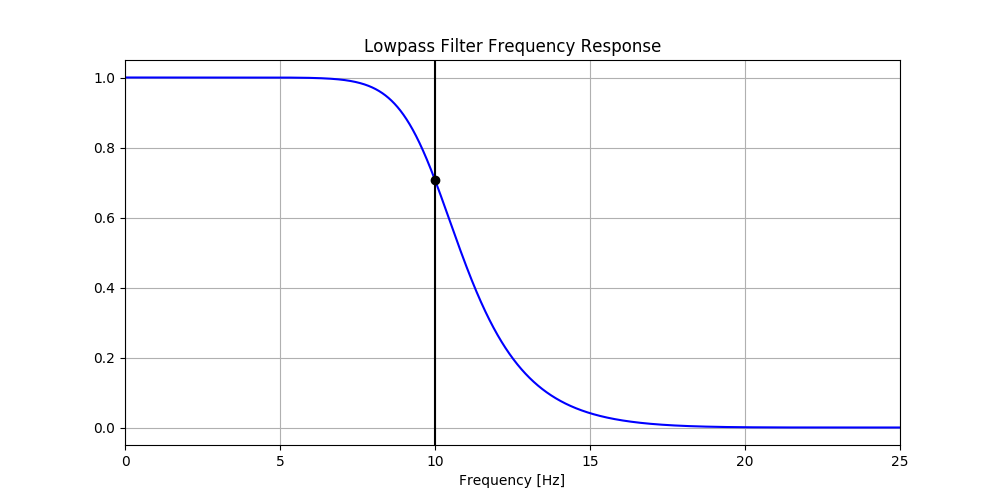

In [12]:
w, h = signal.freqz(b, a,worN=len(df))
plt.figure(figsize=(10, 5))
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(fc, 0.5*np.sqrt(2), 'ko')
plt.axvline(fc, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [13]:
filtered_df = pd.DataFrame()
for sgnl in df.columns:
    if filtered_df.empty:
        filtered_df["DATE"] = df.index
    
    filtered_df["lpf_"+sgnl] = filteredSignal(df[sgnl],b,a)
filtered_df.set_index("DATE",inplace=True)
filtered_df.head()

,lpf_ACC_X,lpf_ACC_Y,lpf_ACC_Z,lpf_EOG_L1,lpf_EOG_R1,lpf_EOG_L2,lpf_EOG_R2,lpf_EOG_H1,lpf_EOG_H2,lpf_EOG_V1,lpf_EOG_V2
DATE,,,,,,,,,,,
2018-03-15 17:59:16.130,-379.986931,2276.001130,-16281.004006,137.875726,169.869295,-10.915830,20.082324,-31.993568,-30.998154,-153.872756,-4.083133
2018-03-15 17:59:16.150,-378.626122,2227.701317,-16200.961346,19.519879,46.981804,94.817691,124.964881,-27.461925,-30.147190,-33.257141,-109.462079
2018-03-15 17:59:16.170,-367.930380,2225.504070,-16185.898917,-16.195211,11.570844,108.347142,137.192851,-27.766055,-28.845708,2.415438,-122.504580
2018-03-15 17:59:16.190,-351.093709,2264.392007,-16236.138285,32.712194,64.337698,44.705988,72.325833,-31.625504,-27.619845,-48.242075,-58.481534
2018-03-15 17:59:16.210,-339.629790,2299.008554,-16291.443082,90.508834,124.041414,0.905802,28.279592,-33.532581,-27.373789,-106.916218,-14.718871


In [14]:
df.describe()

,ACC_X,ACC_Y,ACC_Z,EOG_L1,EOG_R1,EOG_L2,EOG_R2,EOG_H1,EOG_H2,EOG_V1,EOG_V2
count,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000
mean,-1468.331425,5603.081199,-14321.289319,-14.972130,79.423396,-15.054610,79.367882,-94.395526,-94.422492,-32.107261,-32.039997
std,2984.298435,3691.873722,3225.953578,261.942142,242.145607,261.596806,242.310094,272.855911,272.223227,212.069421,212.146189
min,-32767.000000,-14604.000000,-29666.000000,-2048.000000,-2048.000000,-2048.000000,-2048.000000,-3853.000000,-3854.000000,-1894.000000,-1893.000000
25%,-2727.000000,2534.000000,-16192.000000,-56.000000,30.000000,-57.000000,32.000000,-154.000000,-154.000000,-80.000000,-80.000000
50%,-402.500000,5660.500000,-15189.000000,-29.000000,97.000000,-28.000000,97.000000,-91.000000,-89.000000,-33.000000,-34.000000
75%,107.250000,9135.000000,-13285.000000,47.000000,131.000000,47.000000,131.000000,-34.000000,-34.000000,4.000000,4.000000
max,19662.000000,22075.000000,32767.000000,2026.000000,1821.000000,2024.000000,1824.000000,4074.000000,4072.000000,2040.000000,2040.000000


In [15]:
filtered_df.describe()

,lpf_ACC_X,lpf_ACC_Y,lpf_ACC_Z,lpf_EOG_L1,lpf_EOG_R1,lpf_EOG_L2,lpf_EOG_R2,lpf_EOG_H1,lpf_EOG_H2,lpf_EOG_V1,lpf_EOG_V2
count,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000,13276.000000
mean,-1468.319315,5603.088477,-14321.303481,-14.971980,79.422448,-15.056254,79.366321,-94.394427,-94.422575,-32.106882,-32.038396
std,2871.718234,3678.313016,3164.568419,252.588892,232.290016,252.283711,232.425537,266.043222,265.738964,202.870326,202.851829
min,-26317.234482,-13634.249027,-23687.871998,-2411.719734,-2395.298667,-2455.576458,-2358.143352,-4253.930084,-4202.146920,-2087.864259,-2153.356096
25%,-2725.609377,2537.142088,-16193.636814,-49.364654,50.861835,-49.403764,50.840806,-153.851274,-153.846564,-66.557645,-66.227745
50%,-425.156127,5659.712379,-15189.845213,-12.730902,90.445740,-12.714722,90.137977,-93.808768,-94.073290,-37.545957,-37.334382
75%,104.626885,9134.192205,-13286.452783,38.714032,115.793595,38.778423,115.685770,-33.477859,-33.470133,-15.031850,-15.134056
max,7039.882729,21160.956528,22965.708522,2199.077585,2347.546598,2230.129705,2288.616115,4363.864281,4416.263934,2393.735500,2346.391500


In [16]:
for sgnl in df.columns:
    print("---------- "+sgnl+" ----------")
    print(np.corrcoef(filtered_df["lpf_"+sgnl],df[sgnl]))
    print(" ")

---------- ACC_X ----------
[[1.         0.96576503]
 [0.96576503 1.        ]]
 
---------- ACC_Y ----------
[[1.         0.99685507]
 [0.99685507 1.        ]]
 
---------- ACC_Z ----------
[[1.         0.98209273]
 [0.98209273 1.        ]]
 
---------- EOG_L1 ----------
[[1.        0.9795244]
 [0.9795244 1.       ]]
 
---------- EOG_R1 ----------
[[1.         0.97744445]
 [0.97744445 1.        ]]
 
---------- EOG_L2 ----------
[[1.         0.97944222]
 [0.97944222 1.        ]]
 
---------- EOG_R2 ----------
[[1.        0.9770446]
 [0.9770446 1.       ]]
 
---------- EOG_H1 ----------
[[1.         0.98381636]
 [0.98381636 1.        ]]
 
---------- EOG_H2 ----------
[[1.         0.98471474]
 [0.98471474 1.        ]]
 
---------- EOG_V1 ----------
[[1.         0.97643266]
 [0.97643266 1.        ]]
 
---------- EOG_V2 ----------
[[1.         0.97574805]
 [0.97574805 1.        ]]
 


<IPython.core.display.Javascript object>


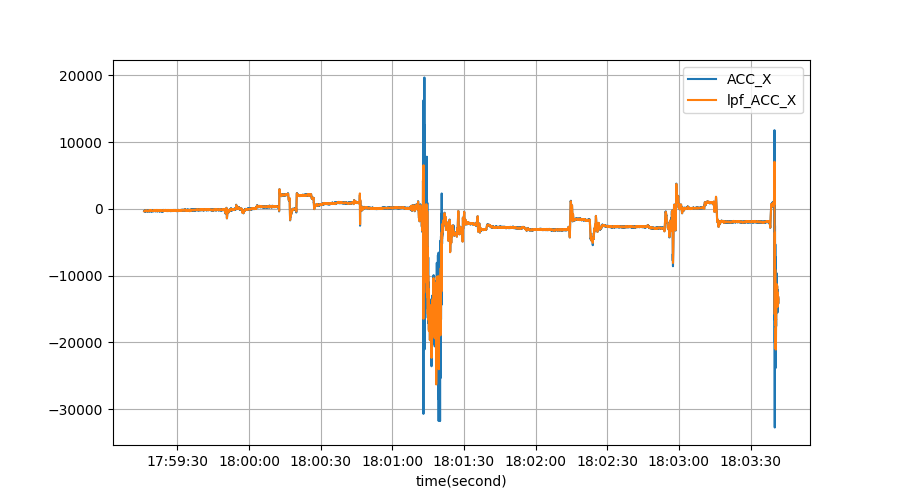

<IPython.core.display.Javascript object>


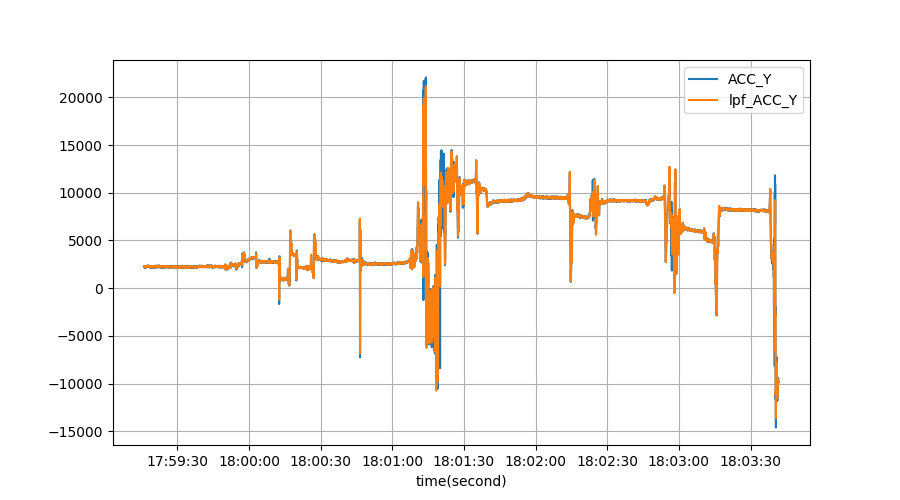

<IPython.core.display.Javascript object>


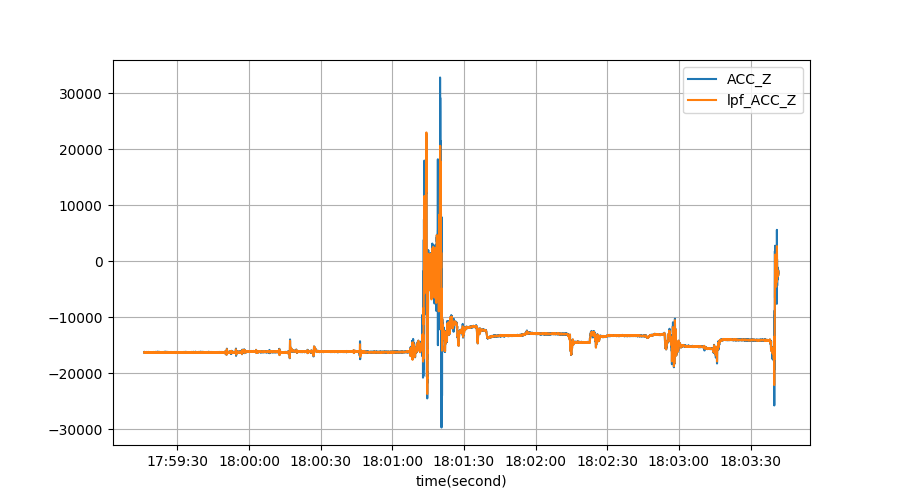

<IPython.core.display.Javascript object>


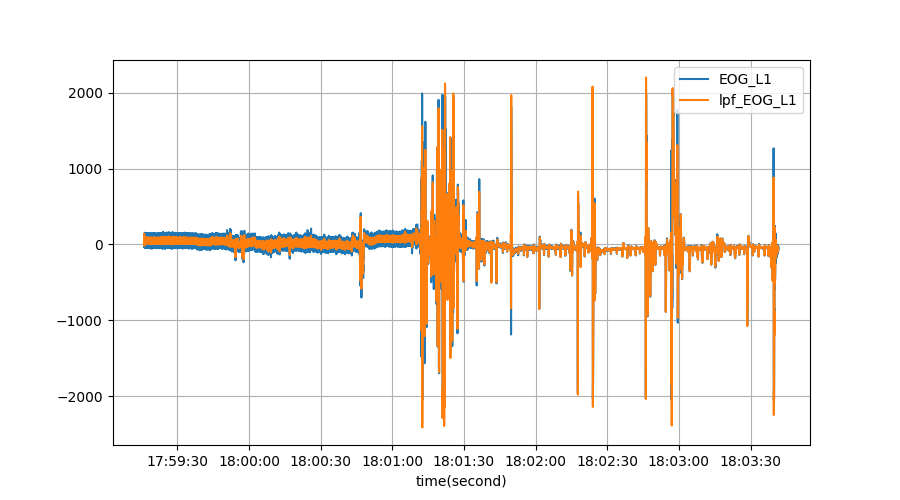

<IPython.core.display.Javascript object>


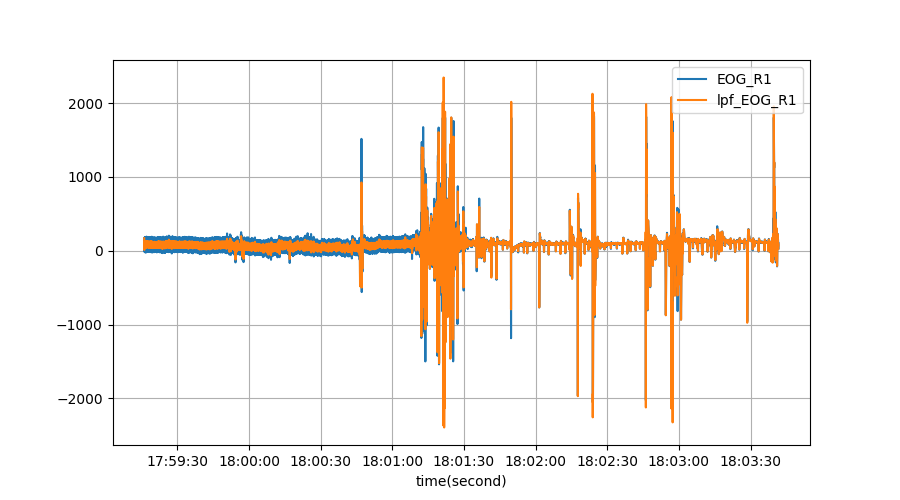

<IPython.core.display.Javascript object>


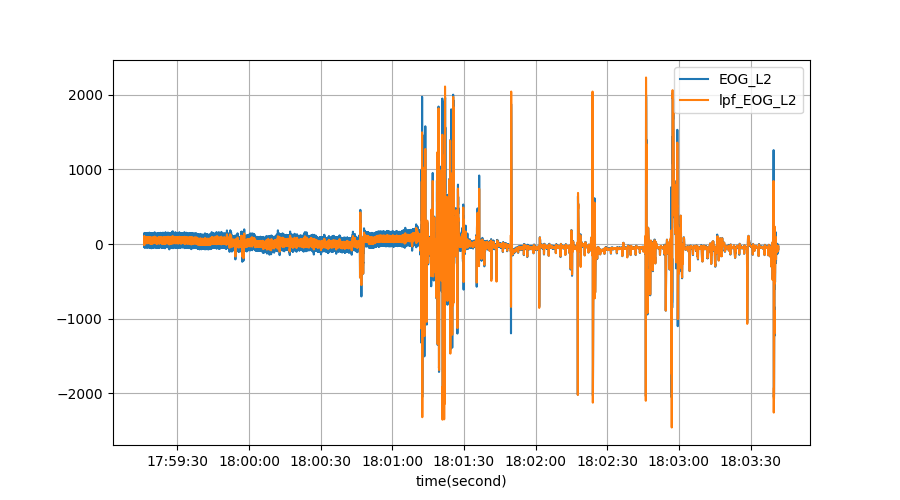

<IPython.core.display.Javascript object>


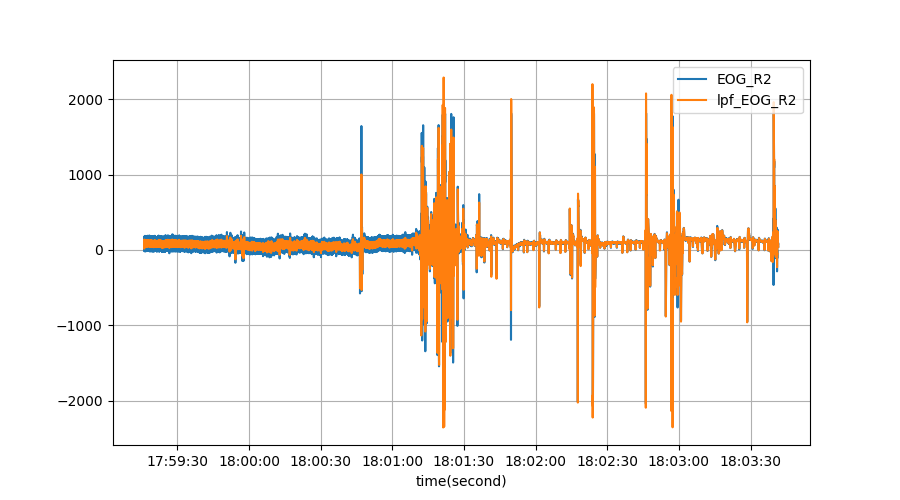

<IPython.core.display.Javascript object>


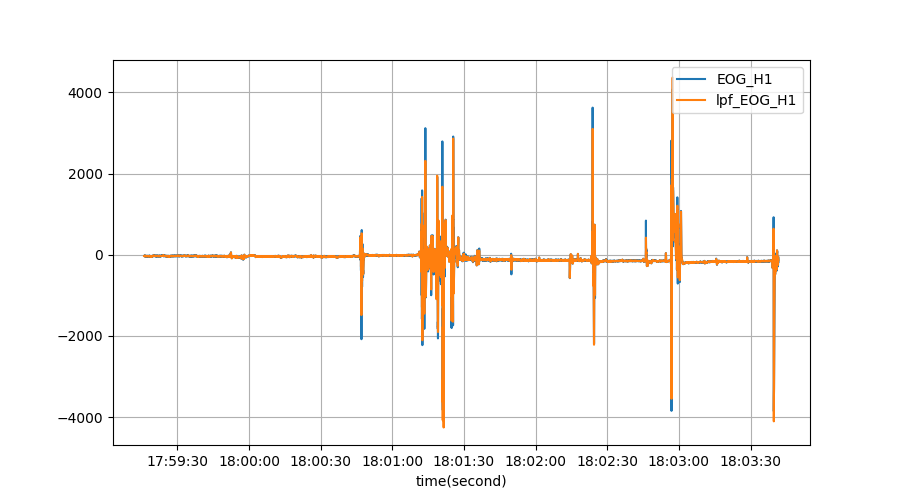

<IPython.core.display.Javascript object>


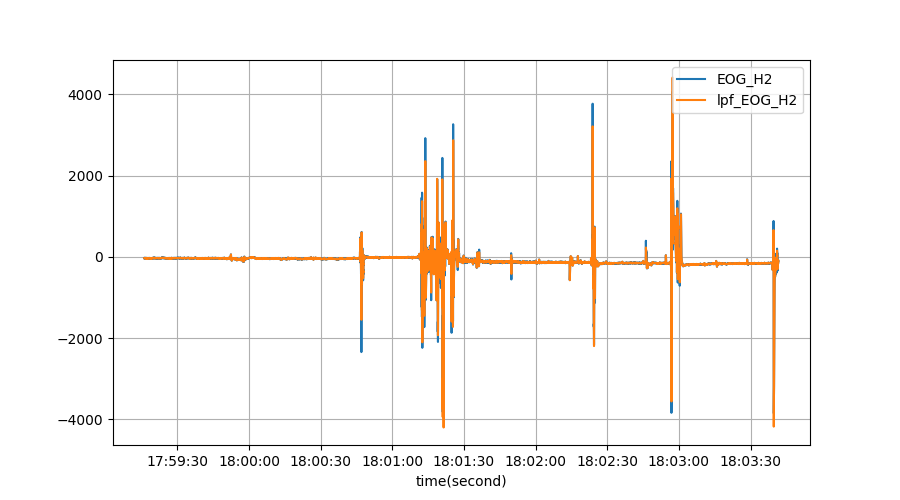

<IPython.core.display.Javascript object>


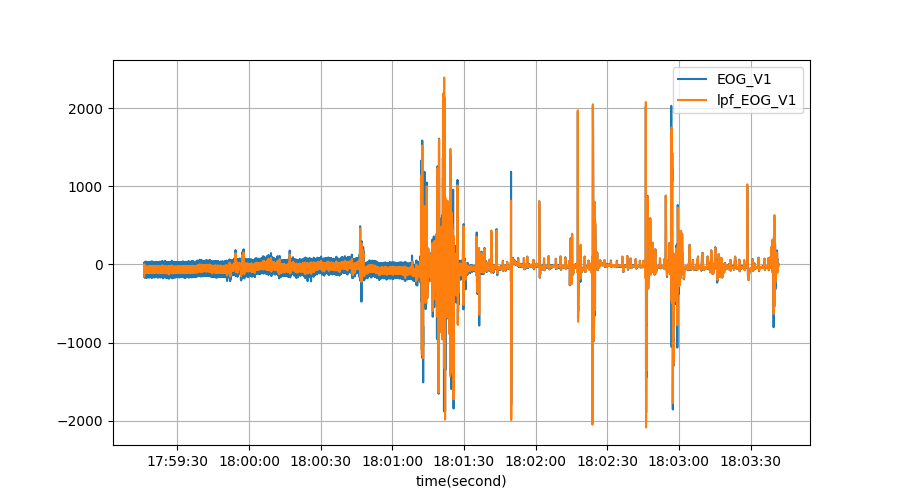

<IPython.core.display.Javascript object>


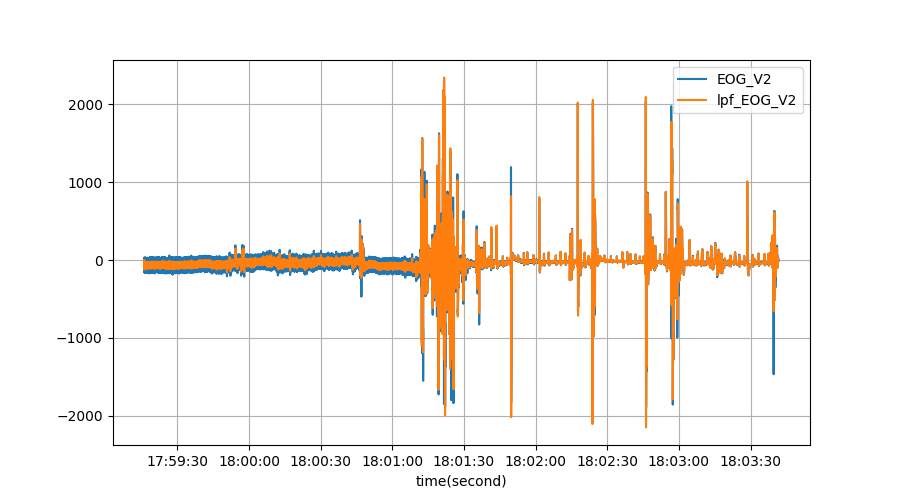

In [17]:
for sgnl in df.columns:
    plt.figure(figsize=(9, 5))
    plt.plot(df.index,df[sgnl],label = sgnl)
    plt.plot(df.index,filtered_df["lpf_"+sgnl],label = "lpf_"+sgnl)
    plt.grid()
    plt.xlabel('time(second)')
    plt.legend(loc='upper right')
    plt.show()

<IPython.core.display.Javascript object>


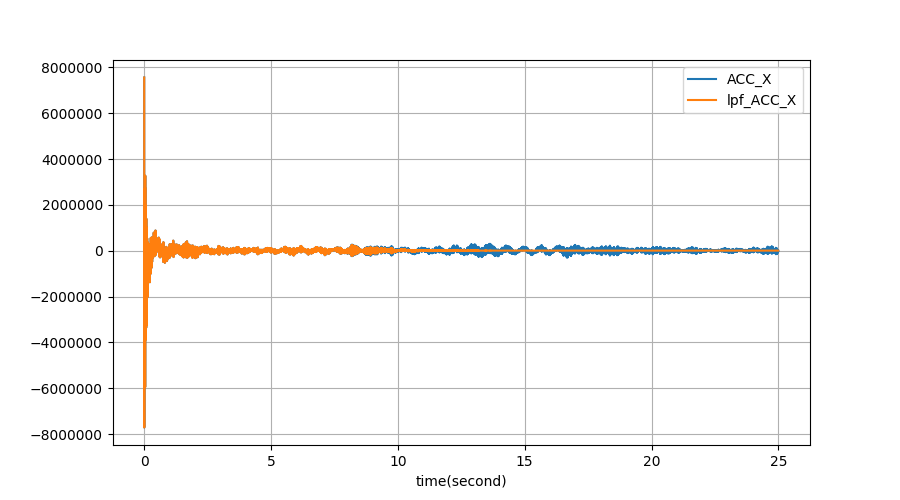

<IPython.core.display.Javascript object>


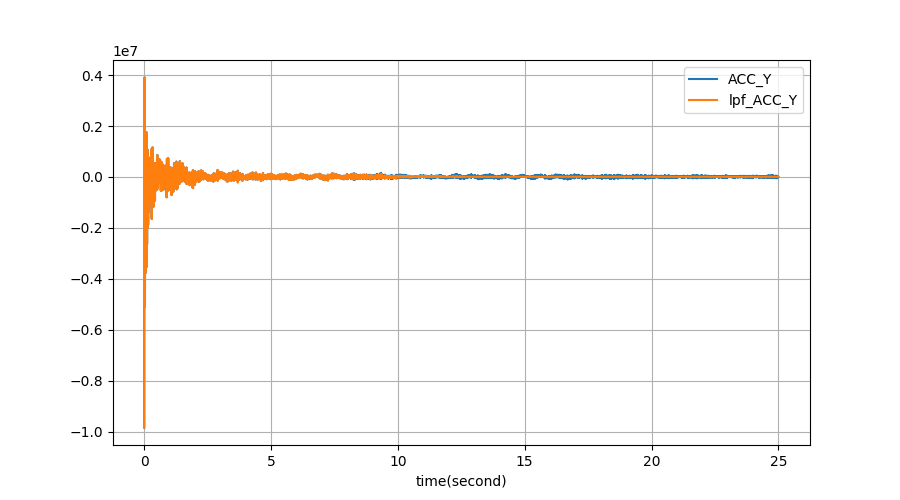

<IPython.core.display.Javascript object>


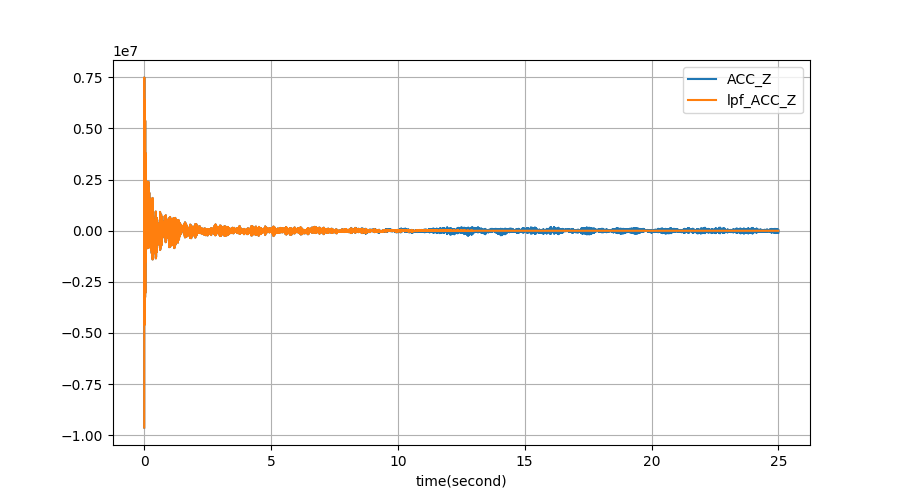

<IPython.core.display.Javascript object>


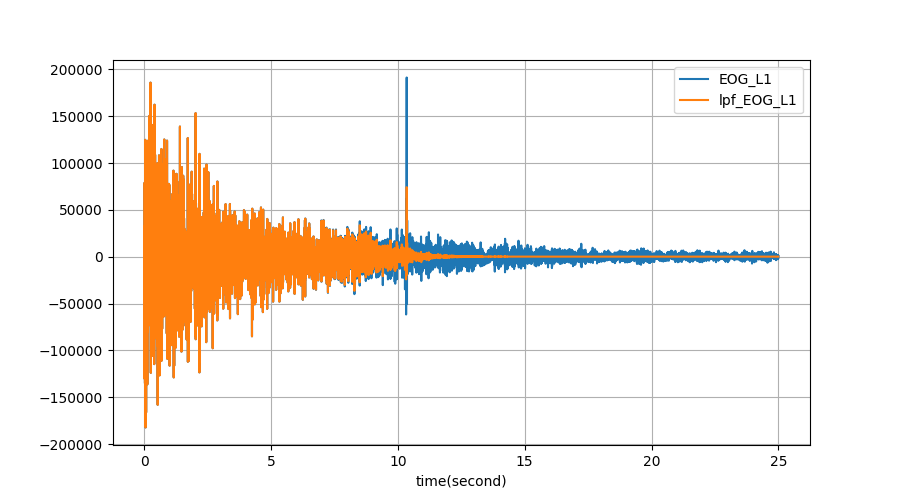

<IPython.core.display.Javascript object>


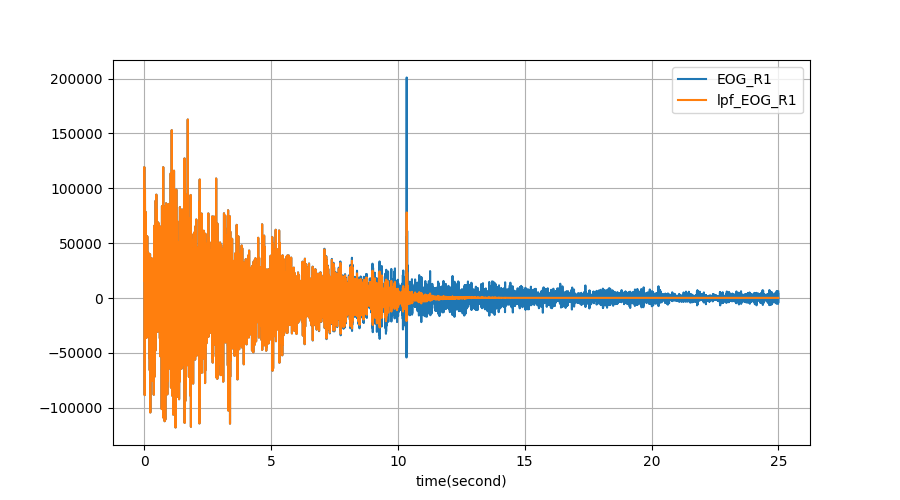

<IPython.core.display.Javascript object>


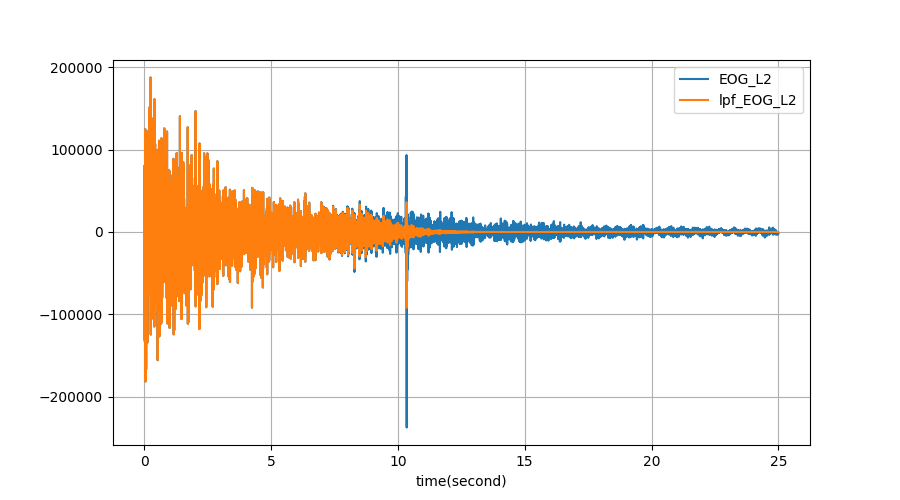

<IPython.core.display.Javascript object>


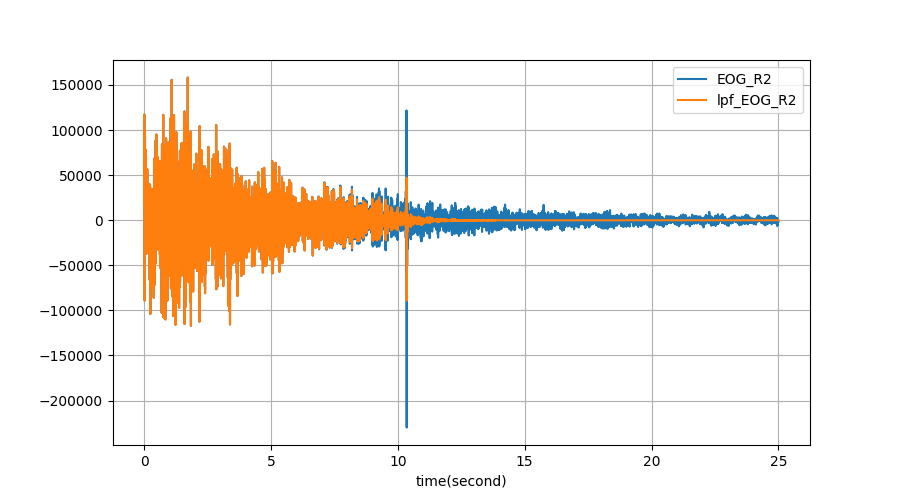

<IPython.core.display.Javascript object>


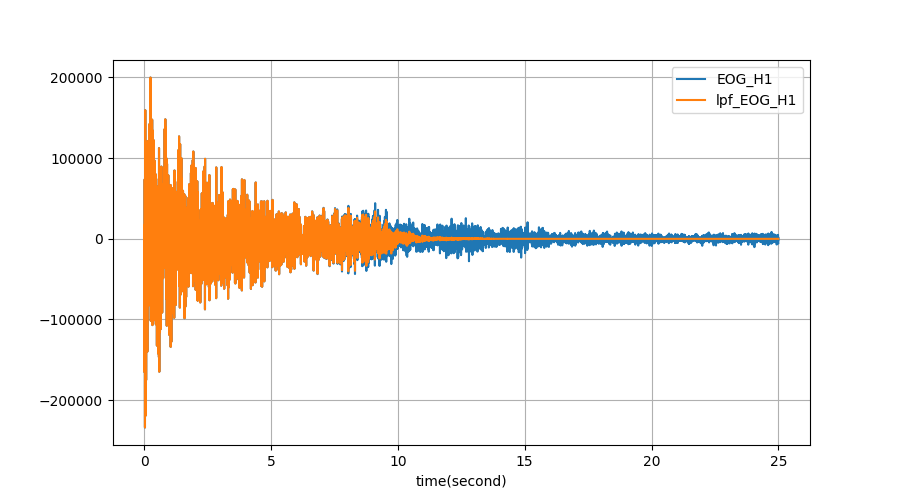

<IPython.core.display.Javascript object>


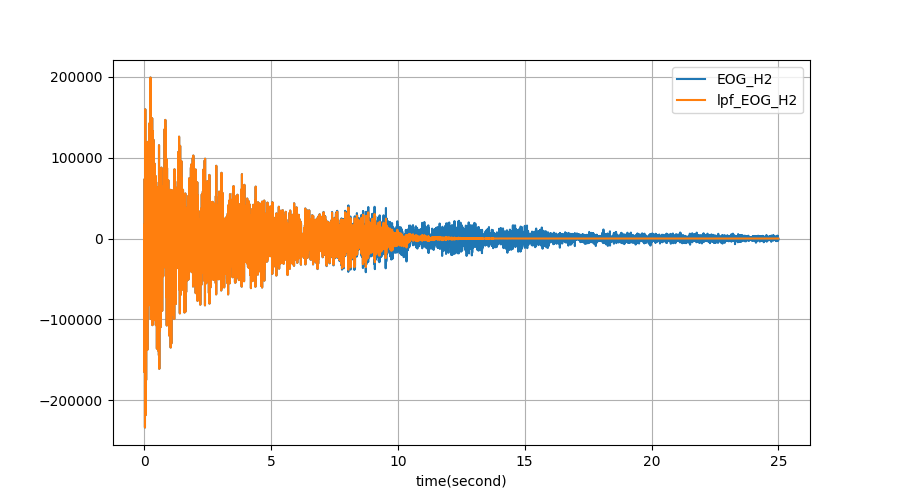

<IPython.core.display.Javascript object>


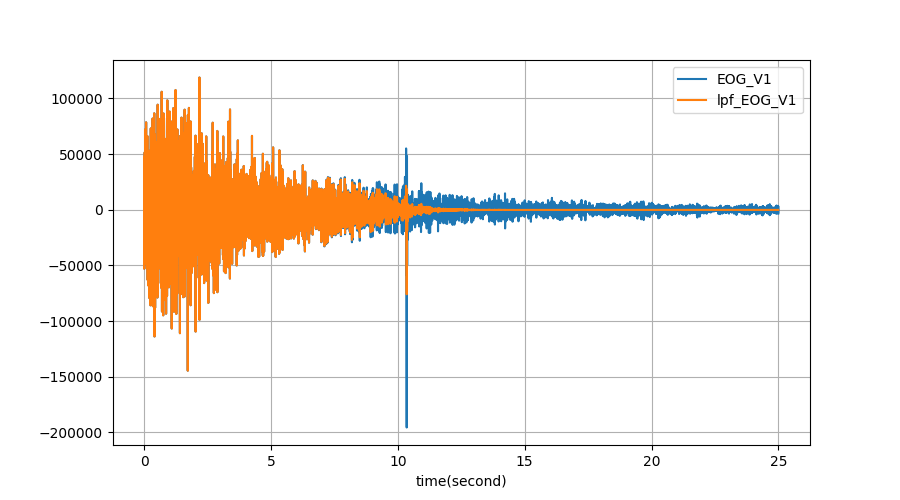

<IPython.core.display.Javascript object>


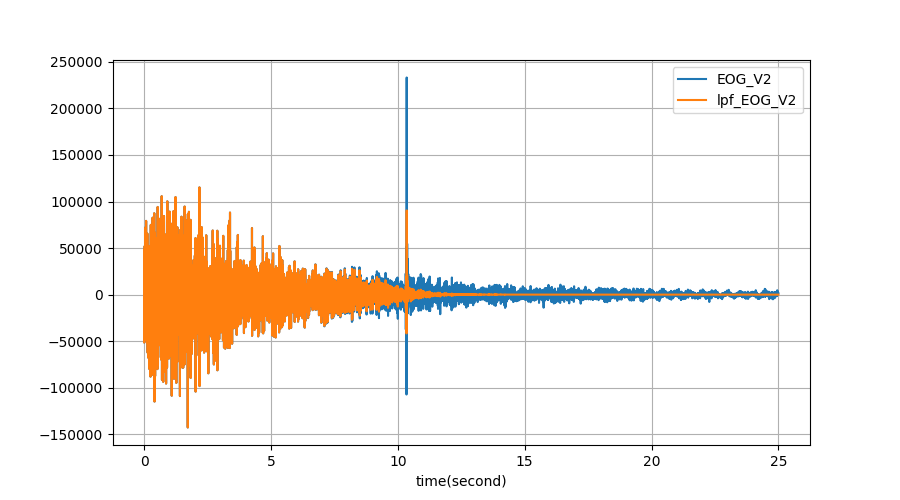

In [18]:
for sgnl in df.columns:
    f1,a1 = applyFFTsignal(df[sgnl],d)
    f2,a2 = applyFFTsignal(filtered_df["lpf_"+sgnl],d)
    plt.figure(figsize=(9, 5))
    plt.plot(f1,a1,label = sgnl)
    plt.plot(f2,a2,label = "lpf_"+sgnl)
    plt.grid()
    plt.xlabel('time(second)')
    plt.legend(loc='upper right')
    plt.show()